In [1]:
import copy
import sys
sys.path.insert(0, "..")
from classes.atoms import Atom, Atom_Collection, create_atom_col_copies
from classes.calculators.lennardjones import LennardJones
from classes.optimizers.random_struct_search import Line_searcher
from classes.optimizers.md_simulator import MD_simulator_new1 as MD_sim
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

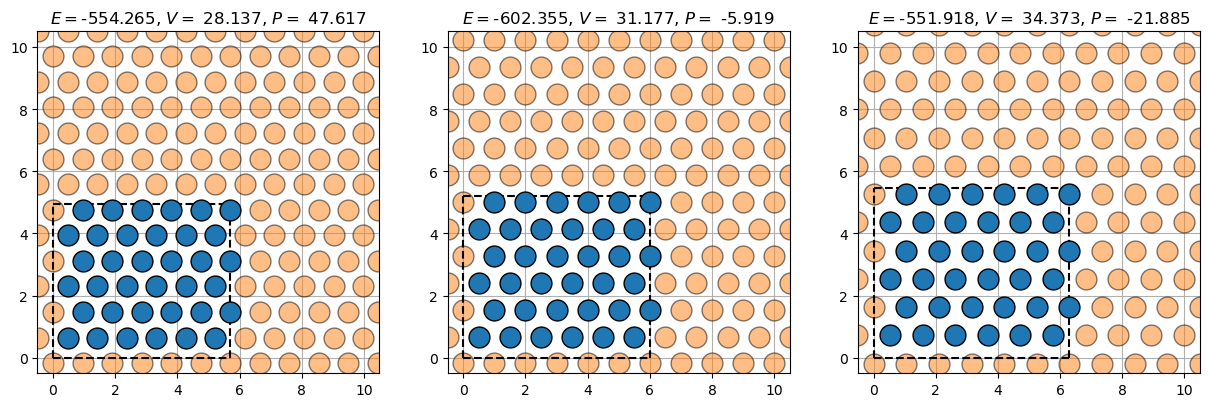

In [39]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

unit_cell = (np.array([2.0, 0.0]), np.cos(np.pi/6.0)*np.array([0.0,2.0]))
atom_poses = [np.array([0.0,0.0]), np.array([0.5,0.5]), np.array([1.0,0.0]), np.array([1.5,0.5])]
atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=30) for pos in atom_poses], unit_cell=unit_cell, pbc=True)
atom_col.calculator = LennardJones()
optimizer = Line_searcher(atom_col=atom_col)
pos_opt, f = optimizer.run(fmax=0.05)
opt_col = create_atom_col_copies(atom_col=atom_col, positions=pos_opt, velocities=np.zeros(shape=pos_opt.shape))[0]
l1, l2 = unit_cell
new_poses = []
for i in [0.0, 1.0, 2.0]:
    for j in [0.0, 1.0, 2.0]:
        disp_pos = pos_opt + l1*i + l2*j
        new_poses.append(disp_pos)

unit_cell = (np.array([6.0, 0.0]), 3*np.cos(np.pi/6.0)*np.array([0.0,2.0]))
scaling_factors = [-0.05, 0.0, 0.05]
scaled_cols = []
for ax, scaling_factor in zip(axs, scaling_factors):
    ax.set_xlim([-0.5,10.5])
    ax.set_ylim([-0.5,10.5])
    ax.grid()
    ax.set_aspect("equal")
    atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=20) for pos in np.array(new_poses).reshape(6**2, 2)], unit_cell=unit_cell, pbc=True)
    atom_col.calculator = LennardJones()
    atom_col.scale_volume(scale_x=scaling_factor, scale_y=scaling_factor)
    vol = atom_col.volume
    p = atom_col.get_pressure(step_size=1e-4)
    ax.set_title(rf"$E = ${atom_col.get_potential_energy().round(3)}, $V = $ {vol.round(3)}, $P = $ {p.round(3)}")
    atom_col.plot_cells(ax=ax, size=15)
    atom_col.reset_plot_axes()
    scaled_cols.append(atom_col)

In [3]:
md_simulator = MD_sim(atom_col=scaled_cols[0], temp=0.15)
ts, poses, vols, stresses, vels = md_simulator.run_MD_simulation(N_steps=50, time_step=0.001, apply_barostat=True, apply_thermostat=False)
pressures = []
for stress, vol in zip(stresses, vols):
    pressures.append(np.mean(stress.diagonal())/vol)

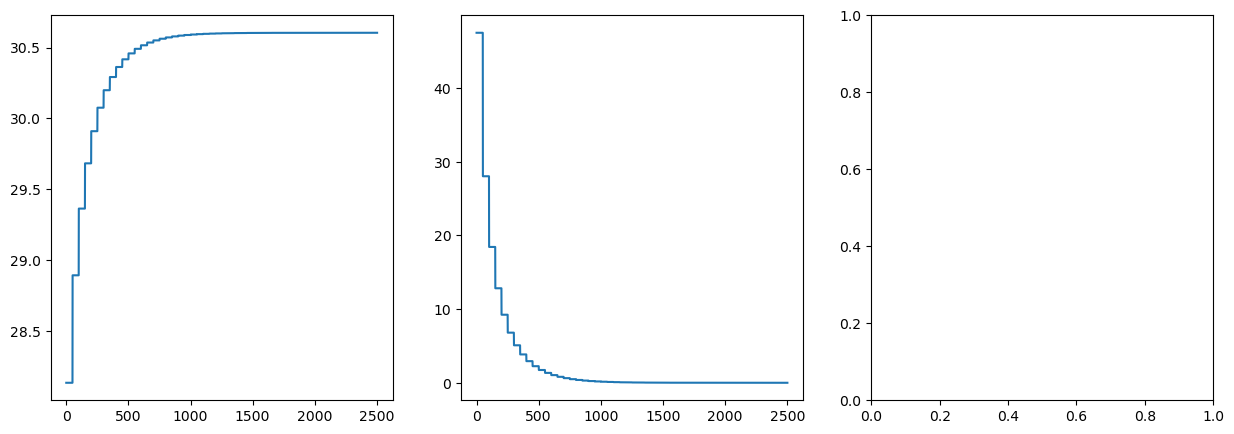

In [4]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
xs = np.linspace(0, len(vols), len(vols))
axs[0].plot(xs, vols)
axs[1].plot(xs, pressures)
#axs[2].plot(xs, energies)

In [29]:
atom_list = [Atom(position=pos) for pos in poses[-1]]
p0_col = Atom_Collection(atomlist=atom_list, unit_cell=(md_simulator.pbc_handler.v1*1.0, md_simulator.pbc_handler.v2*1.0), pbc=True)

In [37]:
temps = [0.40,0.45,0.50,0.55,0.60]
vols_total = []
stresses_total = []
positons_total = []
vels_total = []
md_simulator = MD_sim(p0_col, temp=0.15)
for temp in temps:
    md_simulator.temp=temp
    ts, poses, vols, stresses, vels = md_simulator.run_MD_simulation(N_steps=400, time_step=0.001, apply_barostat=True, apply_thermostat=True)
    vols_total.append(vols)
    stresses_total.append(stresses)
    vels_total.append(vels)
    positons_total.append(poses)

In [38]:
print(np.mean(vols_total, axis=1))

[30.96725073 31.01461327 31.05134607 31.09826602 31.15886395]
